Initial QPU Sizes:  {0: 9, 1: 9, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9, 10: 9, 11: 9, 12: 9, 13: 9, 14: 9, 15: 9}


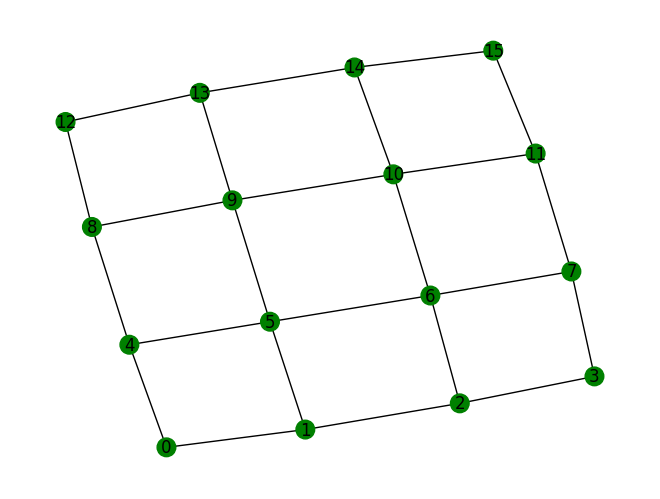

Initial Cost:  7570


In [16]:
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from disqco.graphs.hypergraph_methods import calculate_full_cost_hetero
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions
from disqco.circuits.QAOA import QAOA_random
from qiskit.circuit.library import QFT, QuantumVolume
import pickle
from copy import deepcopy
from disqco.graphs.quantum_network import *
from disqco.parti.FM.multilevel_FM import MLFM_recursive_hetero
import networkx as nx
import networkx as nx
from copy import deepcopy



num_qubits = 128

circuit = QAOA_random(num_qubits, prob = 0.5, reps = 1)

circuit = QFT(num_qubits,do_swaps = False)

# circuit = QuantumVolume(num_qubits, depth = 8)

circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.5)

# circuit = cz_fraction(  num_qubits=num_qubits,
                        # depth=num_qubits,
                        # fraction= 0.5)


circuit = transpile(circuit, basis_gates = ['cp', 'u'])
depth = circuit.depth()



num_partitions = 16


initial_qpu_sizes = {i: int(circuit.num_qubits/num_partitions)+1 for i in range(num_partitions)}

print("Initial QPU Sizes: ", initial_qpu_sizes)

qpu_sizes = deepcopy(initial_qpu_sizes)

coupling = linear_coupling(num_partitions)   

coupling = grid_coupling(num_partitions)


# coupling = random_coupling(num_partitions, 0.5)

# coupling = None

from disqco.graphs.quantum_network import QuantumNetwork

initial_network = QuantumNetwork(qpu_sizes, coupling)

initial_network.draw()

network = deepcopy(initial_network)

initial_graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)


graph = deepcopy(initial_graph)
assignment = set_initial_partitions(network, num_qubits, depth, num_partitions)

initial_cost = calculate_full_cost_hetero(hypergraph=graph, assignment=assignment, num_partitions=num_partitions, costs = {}, network=network)

print("Initial Cost: ", initial_cost)

In [17]:
from disqco.graphs.coarsening.network_coarsener import NetworkCoarsener

net_coarsener = NetworkCoarsener(initial_network)


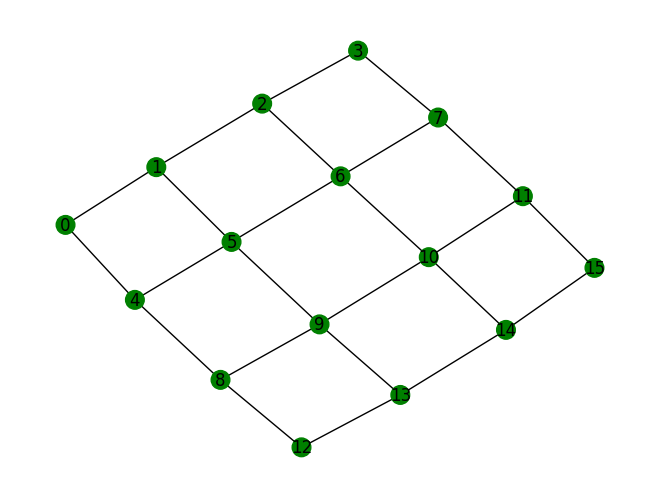

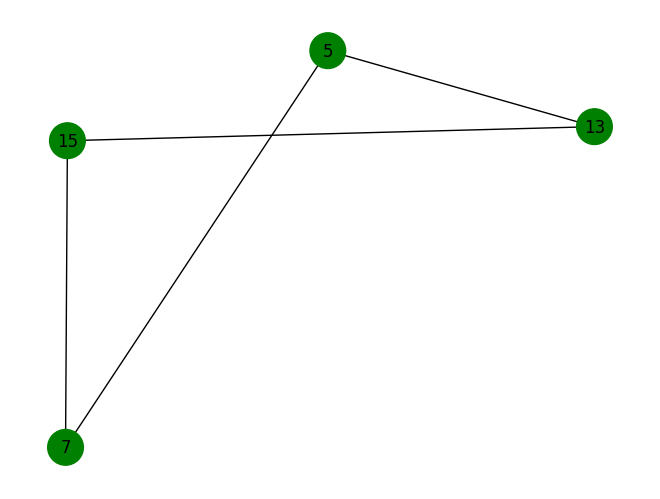

In [18]:
net_coarsener.coarsen_network_recursive(l = 4)

for network in net_coarsener.network_coarse_list:
    network.draw()

In [19]:
network_coarse = net_coarsener.network_coarse_list[-1]  
num_partitions_coarse = network_coarse.qpu_graph.number_of_nodes()
node_map = network_coarse.node_map  
qpu_sizes_coarse = network_coarse.qpu_sizes

print("QPU Sizes Coarse: ", qpu_sizes_coarse)
print("Node Map Coarse: ", node_map)

QPU Sizes Coarse:  {5: 33, 7: 33, 13: 33, 15: 33}
Node Map Coarse:  {0: 5, 1: 7, 2: 13, 3: 15}


In [20]:
from disqco.graphs.hypergraph_methods import get_all_configs, get_all_costs_hetero
from disqco.parti.FM.FM_methods import set_initial_sub_partitions, order_nodes


configs_coarse = get_all_configs(num_partitions_coarse, hetero=True)

costs_coarse, edge_tree = get_all_costs_hetero(network_coarse, configs_coarse, node_map=node_map)
node_list = order_nodes(graph)
assignment_coarse = set_initial_sub_partitions(network_coarse, node_list, set([node for node in network_coarse.qpu_graph.nodes()]))

print("Assignment Coarse: ", assignment_coarse)

Assignment Coarse:  [[0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 ...
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]]


In [21]:
from disqco.parti.FM.FM_hetero import run_FM_hetero
from disqco.drawing.tikz_drawing import draw_graph_tikz
from disqco.parti.FM.multilevel_FM import MLFM_recursive_hetero
import numpy as np
%load_ext jupyter_tikz

# final_cost_coarse, final_assignment_coarse, cost_list_coarse = run_FM_hetero(
#     hypergraph = graph,
#     initial_assignment = assignment_coarse,
#     qpu_info = qpu_sizes_coarse,
#     num_partitions = num_partitions_coarse,
#     limit = num_qubits*depth*0.125,
#     passes = 100,
#     stochastic = True,
#     active_nodes = None,
#     log = False,
#     add_initial = False,
#     costs = None,
#     network = network_coarse,
#     node_map = node_map
# )

assignment_list_coarse, cost_list_coarse, _ = MLFM_recursive_hetero(
    graph = graph,
    initial_assignment = assignment_coarse,
    qpu_info = qpu_sizes_coarse,
    costs=costs_coarse,
    network = network_coarse,
    node_map = node_map,
    log = True
)   

final_cost_coarse = min(cost_list_coarse)

final_assignment_coarse = assignment_list_coarse[np.argmin(cost_list_coarse)]

print("Final Assignment Coarse: ", final_assignment_coarse)
print("Final Cost: ", final_cost_coarse)

if num_qubits <= 32:
    fig = draw_graph_tikz(graph, final_assignment_coarse, qpu_sizes_coarse)
    display(fig)


The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz
Initial cost: 2910
All passes complete.
Final cost: 2436
Best cost at level 0: 2436
Initial cost: 2436
All passes complete.
Final cost: 2287
Best cost at level 1: 2287
Initial cost: 2287
All passes complete.
Final cost: 2171
Best cost at level 2: 2171
Initial cost: 2171
All passes complete.
Final cost: 2069
Best cost at level 3: 2069
Initial cost: 2069
All passes complete.
Final cost: 1962
Best cost at level 4: 1962
Initial cost: 1962
All passes complete.
Final cost: 1900
Best cost at level 5: 1900
Initial cost: 1900
All passes complete.
Final cost: 1856
Best cost at level 6: 1856
Initial cost: 1856
All passes complete.
Final cost: 1851
Best cost at level 7: 1851
Final Assignment Coarse:  [[2 1 3 ... 3 0 2]
 [2 1 3 ... 3 0 2]
 [2 1 3 ... 3 0 2]
 ...
 [1 0 0 ... 0 1 2]
 [1 0 0 ... 0 1 2]
 [1 0 0 ... 0 1 2]]
Final Cost:  1851


In [22]:

# for layer in final_assignment_coarse:
#     print(layer)

# def balance_assignment(graph, assignment, num_partitions):
#     """
#     Balance the assignment of qubits to partitions in a quantum circuit hypergraph.
    
#     Parameters:
#         graph (QuantumCircuitHyperGraph): The quantum circuit hypergraph.
#         assignment (list): The current assignment of qubits to partitions.
    
#     Returns:
#         list: The balanced assignment of qubits to partitions.
#     """
#     # Calculate the size of each partition
#     qpu_counts_t = [[0 for _ in range(num_partitions)] for _ in range(len(assignment))]
#     print(qpu_counts_t)
#     for node in graph.nodes:
#         t = node[1]
#         q = node[0]
#         partition = assignment[t][q]
#         qpu_counts_t[t][partition] += 1
#     print(qpu_counts_t)
#     return

# balance_assignment(graph, final_assignment_coarse, num_partitions_coarse)

mapping_coarse = network_coarse.mapping

In [23]:
from disqco.parti.FM.FM_methods import transform_assignment




# print(mapping_list[-1])

assignment_uncoarsened = transform_assignment(final_assignment_coarse, mapping_coarse, qpu_sizes, node_map)

for layer in assignment_uncoarsened:
    print(layer)

[ 8  2 10 10  8  0  8  8  8  2  2  0 10  2 10  0  0  0  2  0 10  2  0  2
  2  8  8  8  0  0 10 10  8  2  3  9  9 10  3  1  3  3  3 10  3  3 11 11
  3  3  6  9  1  1  6  9  6 11  1  9  9  1  9  1  6  9  9  1  1  1 12 12
 11 11 11  4 11  4 12 12  4  4 12 11  6  6  4 11 12 14 14  4  4 14 14  4
  4 12  6  6  6  5  7 12  7  5  7 14  5 12  5 14  7 13  7  7 14 14 13 14
 15 15  5 13 15 15  5 13]
[ 8  2 10 10  8  0  8  8  8  2  2  0 10  2 10  0  0  0  2  0 10 10  0  2
  2  8  8  8  0  0 10 10  8  2  2  9  9 10  3  1  3  3  3 11  3  3 11 11
  3  3  3  9  1  1  1  9  6 11  1  9  9  1  9  1  6  9  9  1  1 12 12 12
 11 11 11  4 11  4 12 12  4  4 12 11  6  6  4 14 12 14 14  4  4 14 14  4
  4 12  6  6  6  5  6 12  6  5  7 14  5 13  5 14  7 13  7  7 14 14 13 15
 15 15  5 13 15 15  5 13]
[ 8  2 10 10 10  0  8  8  8  2  2  0 10  2 10  0  0  0  2  0 10 10  0  2
  2  8  8  8  0  0 10 10  8  2  2  8  9 11  3  1  3  3  3 11  3  3 11 11
  3  3  3  9  1  1  1  9  6 11  1  9  1  1  9  1  6  9  9  1  4  9  9 12

In [24]:
from disqco.parti.FM.FM_methods import calculate_full_cost_hetero

print(assignment_uncoarsened)
costs = {}
cost = calculate_full_cost_hetero(initial_graph, assignment_uncoarsened, num_partitions, {}, initial_network)
print(cost)



[[ 8  2 10 ... 15  5 13]
 [ 8  2 10 ... 15  5 13]
 [ 8  2 10 ... 15  5 13]
 ...
 [ 2  0  0 ...  5  7 13]
 [ 2  0  0 ...  5  7 13]
 [ 2  0  0 ...  5  7 13]]
7564


In [25]:
from disqco.graphs.GCP_hypergraph import SubGraphManager

sg_manager = SubGraphManager(initial_graph)

subgraphs = sg_manager.build_partition_subgraphs(initial_graph, final_assignment_coarse, num_partitions_coarse)


In [26]:
print(f'Node count in main graph: {len(graph.nodes)}')
print(f'Edge count in main graph: {len(graph.hyperedges)}')

for sgraph in subgraphs:
    # for node in sgraph.nodes:
    #     if isinstance(node, tuple) and len(node) == 3 and node[0] == "dummy":
    #         print("Dummy node:", node)
    #     else:
    #         print("Real node:", node)

    print(f'Total node count: {len(sgraph.nodes)}')
    print(f'Total hyperedge count: {len(sgraph.hyperedges)}')

    


Node count in main graph: 16384
Edge count in main graph: 18026
Total node count: 4079
Total hyperedge count: 5693
Total node count: 4147
Total hyperedge count: 5763
Total node count: 4065
Total hyperedge count: 5673
Total node count: 4105
Total hyperedge count: 5729


In [27]:
from disqco.parti.FM.FM_methods import order_nodes, map_assignment


node_list_list = []
assignment_map_list = []

for g in subgraphs:
    node_list = order_nodes(g)
    max_qubits_layer = max([len(layer) for layer in node_list])
    g.num_qubits = max_qubits_layer
    assignment_map, sorted_node_list = map_assignment(node_list)
    node_list_list.append(sorted_node_list)
    assignment_map_list.append(assignment_map)
    print("Sorted Node List: ", sorted_node_list)
    print("Assignment Map: ", assignment_map)

    



Sorted Node List:  [[5, 11, 15, 16, 17, 19, 22, 28, 29, 39, 52, 53, 58, 61, 63, 67, 68, 69, 75, 77, 80, 81, 86, 91, 92, 95, 96, 101, 105, 108, 110, 122, 126], [5, 11, 15, 16, 17, 19, 22, 28, 29, 39, 52, 53, 54, 58, 61, 63, 67, 68, 75, 77, 80, 81, 86, 91, 92, 95, 96, 101, 105, 108, 110, 122, 126], [5, 11, 15, 16, 17, 19, 22, 28, 29, 39, 52, 53, 54, 58, 60, 61, 63, 67, 68, 75, 77, 81, 86, 91, 95, 96, 101, 105, 108, 110, 122, 126], [5, 11, 15, 16, 17, 19, 22, 28, 29, 39, 52, 53, 54, 58, 60, 61, 63, 67, 68, 75, 77, 81, 95, 96, 101, 105, 108, 110, 122, 126, 127], [5, 9, 11, 15, 16, 17, 19, 22, 28, 29, 39, 53, 54, 58, 60, 61, 63, 67, 68, 75, 77, 81, 85, 95, 96, 101, 105, 108, 110, 117, 122, 126, 127], [5, 11, 15, 16, 17, 19, 22, 28, 29, 39, 53, 54, 58, 60, 61, 63, 67, 75, 77, 81, 85, 95, 96, 101, 105, 108, 110, 117, 122, 126, 127], [5, 11, 15, 16, 17, 19, 22, 28, 29, 53, 54, 58, 60, 61, 63, 67, 75, 77, 81, 85, 95, 96, 101, 105, 108, 110, 117, 122, 126, 127], [11, 15, 16, 17, 19, 22, 28, 29, 

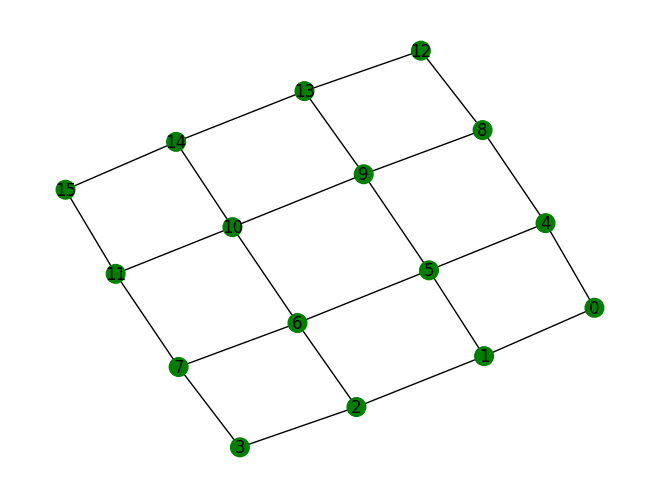

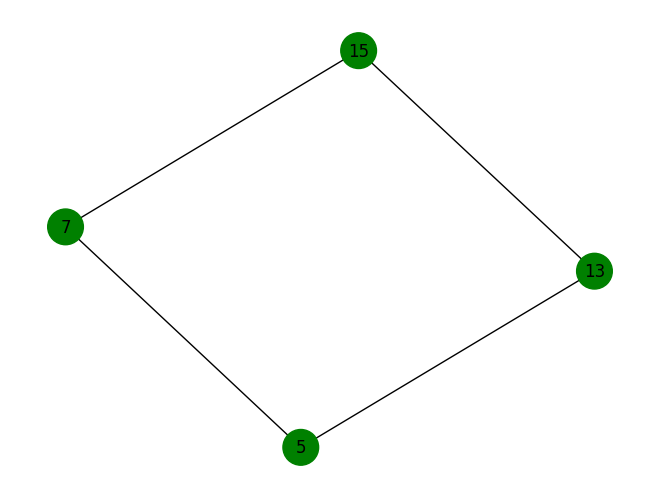

Level:  0
Source node:  5
Sub nodes:  {0, 1, 4, 5}
Mapping:  {5: {0, 1, 4, 5}, 7: {2, 3, 6, 7}, 13: {8, 9, 12, 13}, 15: {10, 11, 14, 15}}
Nodes in g0:  [7, 13, 15]
Nodes to merge:  [7, 13, 15]
Level:  0
Source node:  7
Sub nodes:  {2, 3, 6, 7}
Mapping:  {5: {0, 1, 4, 5}, 7: {2, 3, 6, 7}, 13: {8, 9, 12, 13}, 15: {10, 11, 14, 15}}
Nodes in g0:  [5, 13, 15]
Nodes to merge:  [5, 13, 15]
Level:  0
Source node:  13
Sub nodes:  {8, 9, 12, 13}
Mapping:  {5: {0, 1, 4, 5}, 7: {2, 3, 6, 7}, 13: {8, 9, 12, 13}, 15: {10, 11, 14, 15}}
Nodes in g0:  [5, 7, 15]
Nodes to merge:  [5, 7, 15]
Level:  0
Source node:  15
Sub nodes:  {10, 11, 14, 15}
Mapping:  {5: {0, 1, 4, 5}, 7: {2, 3, 6, 7}, 13: {8, 9, 12, 13}, 15: {10, 11, 14, 15}}
Nodes in g0:  [5, 7, 13]
Nodes to merge:  [5, 7, 13]
Network 0:


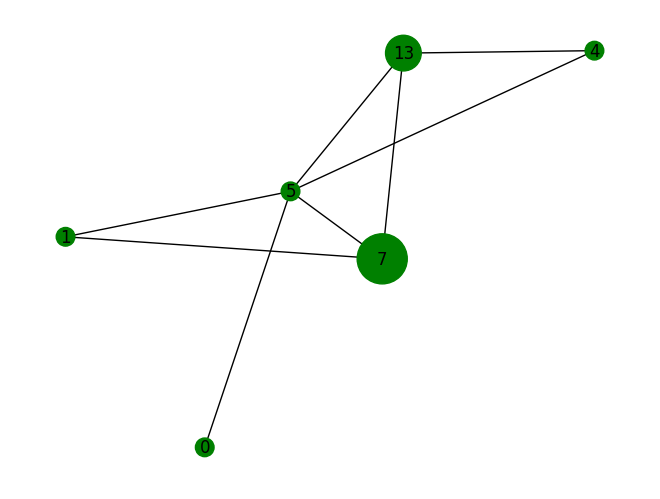

QPU Sizes:  {7: 65, 13: 33, 0: 9, 5: 9, 1: 9, 4: 9}
Coupling:  [(7, 1), (7, 5), (7, 13), (13, 4), (13, 5), (0, 5), (5, 1), (5, 4)]

Network 1:


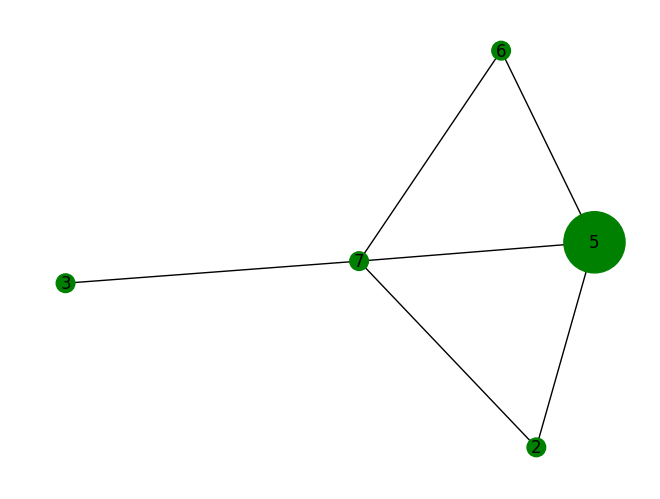

QPU Sizes:  {5: 97, 2: 9, 7: 9, 3: 9, 6: 9}
Coupling:  [(5, 2), (5, 6), (5, 7), (2, 7), (7, 3), (7, 6)]

Network 2:


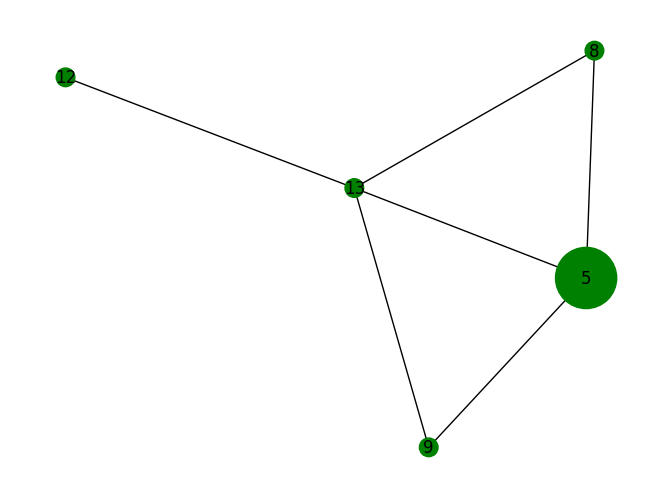

QPU Sizes:  {5: 97, 8: 9, 13: 9, 9: 9, 12: 9}
Coupling:  [(5, 8), (5, 9), (5, 13), (8, 13), (13, 9), (13, 12)]

Network 3:


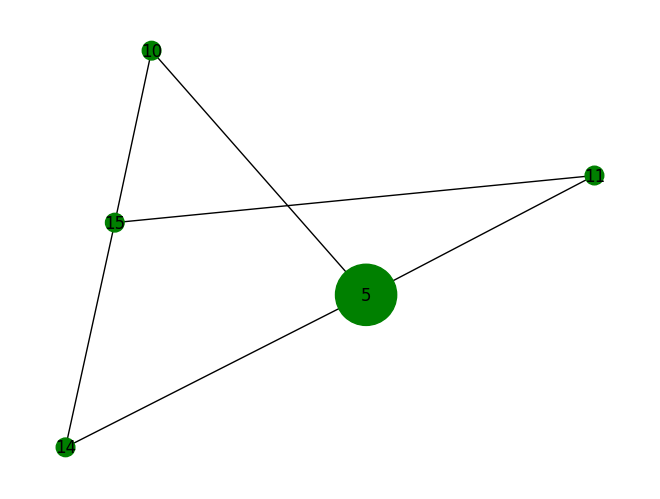

QPU Sizes:  {5: 97, 10: 9, 15: 9, 11: 9, 14: 9}
Coupling:  [(5, 10), (5, 11), (5, 14), (10, 15), (15, 11), (15, 14)]



In [28]:
initial_network.draw()
network_coarse.draw()

network_level_list = []

network_level_list.append([[network_coarse, set([key for key in network_coarse.mapping])]])

for i in range(len(net_coarsener.network_coarse_list)-1):

    networks = net_coarsener.cut_network(level=i)

    for i, (network, active_nodes) in enumerate(networks):
        print(f"Network {i}:")
        network.draw()
        print("QPU Sizes: ", network.qpu_sizes)
        print("Coupling: ", network.qpu_connectivity)
        print()
    
    network_level_list.append(networks)


In [29]:
from disqco.graphs.hypergraph_methods import counts_to_configs



for network_list in network_level_list:
    print("Network List: ", network_list)




Network List:  [[<disqco.graphs.quantum_network.QuantumNetwork object at 0x34bddbee0>, {13, 15, 5, 7}]]
Network List:  [[<disqco.graphs.quantum_network.QuantumNetwork object at 0x16a117d90>, {0, 1, 4, 5}], [<disqco.graphs.quantum_network.QuantumNetwork object at 0x168febed0>, {2, 3, 6, 7}], [<disqco.graphs.quantum_network.QuantumNetwork object at 0x32e5b0560>, {8, 9, 12, 13}], [<disqco.graphs.quantum_network.QuantumNetwork object at 0x3514b1dd0>, {10, 11, 14, 15}]]


In [30]:
from disqco.parti.FM.FM_hetero import run_FM_hetero_dummy
import multiprocessing as mp
from disqco.parti.FM.FM_methods import set_initial_sub_partitions, order_nodes, map_assignment
from disqco.graphs.GCP_hypergraph import SubGraphManager

# coarse_assignments_initial = [set_initial_sub_partitions(network_coarse, order_nodes(initial_graph), set([node for node in network_coarse.qpu_graph.nodes]))]

sub_graph_manager = SubGraphManager(initial_graph)

pool = mp.Pool(processes=mp.cpu_count())
subgraphs = [graph]

for level, network_list in enumerate(network_level_list):
    print("Level: ", level)
    networks = network_list
    sub_assignments = []
    node_maps = []
    inverse_node_maps = []
    qpu_size_list = []  
    sub_partitions_list = []
    dummy_node_list = []
    node_maps = []

    node_list_list = []
    assignment_map_list = []

    for g in subgraphs:
        node_list = order_nodes(g)
        max_qubits_layer = max([len(layer) for layer in node_list])
        g.num_qubits = max_qubits_layer
        assignment_map, sorted_node_list = map_assignment(node_list)
        node_list_list.append(sorted_node_list)
        assignment_map_list.append(assignment_map)



    for i, network_info in enumerate(networks):
        network = network_info[0]
        active_nodes = network_info[1]

        qpu_sizes = {qpu : network.qpu_graph.nodes[qpu]['size'] for qpu in active_nodes}

        qpu_size_list.append(qpu_sizes)
        node_list = order_nodes(subgraphs[i])
        sub_partitions = set_initial_sub_partitions(network, node_list, active_nodes)

        sub_partitions_list.append(sub_partitions)
        subnet, active_nodes = networks[i]

        subnet.qpu_sizes = qpu_size_list[i]
        k = 0
        node_map = {}
        for node in subnet.qpu_graph.nodes:
            if node in active_nodes:
                node_map[k] = node
                k += 1
        
        for node in subnet.qpu_graph.nodes:
            if node not in active_nodes:
                node_map[k] = node
                k += 1
        
        # print("Node Map: ", node_map)
        node_maps.append(node_map)
        subgraph = subgraphs[i]

        dummy_nodes = set()
        for node in subgraph.nodes:
            if node[0] == 'dummy':
                dummy_nodes.add(node)
        dummy_node_list.append(dummy_nodes) 

    # draw_graph_tikz(subgraph, sub_partitions_list[i], qpu_size_list[i], assignment_map=assignment_map_list[i])



    arg_list = [(subgraphs[i],
                sub_partitions_list[i],
                qpu_size_list[i],
                len(networks[i][1]),
                None,
                None,
                50,
                True,
                None,
                False,
                False,
                None,
                networks[i][0],
                node_maps[i],
                assignment_map_list[i],
                dummy_node_list[i]) for i in range(len(networks))
                ]

    # results = pool.starmap(run_FM_hetero_dummy, arg_list)

    results = []
    subgraph_list = []
    print("Number of subgraphs to process: ", len(arg_list))
    for i in range(len(networks)):
        subgraph, assignment, qpu_sizes, num_partitions, limit, max_gain, passes, stochastic, active_nodes, log, add_initial, costs, network, node_map, assignment_map, dummy_nodes = arg_list[i]
        print("Partitioning subgraph ", i)
        print("Qpu_sizes", qpu_sizes)
        print("Node count: ", len(subgraph.nodes))
        print("Edge count: ", len(subgraph.hyperedges))

        final_cost_sub, final_assignment_sub, cost_list_sub = run_FM_hetero_dummy(
            hypergraph=subgraph,
            initial_assignment=assignment,
            qpu_info=qpu_sizes,
            num_partitions=num_partitions,
            limit=num_qubits,
            max_gain=max_gain,
            passes=passes,
            stochastic=False,
            active_nodes=None,
            log=log,
            add_initial=add_initial,
            costs=costs,
            network=network,
            node_map=node_map,
            assignment_map=assignment_map,
            dummy_nodes=dummy_nodes
        )

                                                                    
        if level == len(network_level_list)-1:
            sub_assignments.append(final_assignment_sub)
            subgraph_list = subgraphs
        else:
            subgraphs = sub_graph_manager.build_partition_subgraphs(subgraph, final_assignment_sub, num_partitions, assignment_map=assignment_map)
            subgraph_list += subgraphs
        

    subgraphs = subgraph_list



Level:  0
Number of subgraphs to process:  1
Partitioning subgraph  0
Qpu_sizes {13: 33, 15: 33, 5: 33, 7: 33}
Node count:  16384
Edge count:  18026
Level:  1
Number of subgraphs to process:  4
Partitioning subgraph  0
Qpu_sizes {0: 9, 1: 9, 4: 9, 5: 9}
Node count:  4161
Edge count:  5996


KeyError: 6

In [ ]:
from disqco.parti.FM.FM_hetero import run_FM_hetero_dummy
import multiprocessing as mp
from disqco.parti.FM.FM_methods import set_initial_sub_partitions, order_nodes, map_assignment
from disqco.graphs.GCP_hypergraph import SubGraphManager

# coarse_assignments_initial = [set_initial_sub_partitions(network_coarse, order_nodes(initial_graph), set([node for node in network_coarse.qpu_graph.nodes]))]

sub_graph_manager = SubGraphManager(initial_graph)

pool = mp.Pool(processes=mp.cpu_count())
subgraphs = [graph]

for level, network_list in enumerate(network_level_list):
    print("Level: ", level)
    networks = network_list
    sub_assignments = []
    node_maps = []
    inverse_node_maps = []
    qpu_size_list = []  
    sub_partitions_list = []
    dummy_node_list = []
    node_maps = []

    node_list_list = []
    assignment_map_list = []
    print("Number of subgraphs to process: ", len(subgraphs))

    for g in subgraphs:
        node_list = order_nodes(g)
        max_qubits_layer = max([len(layer) for layer in node_list])
        g.num_qubits = max_qubits_layer
        assignment_map, sorted_node_list = map_assignment(node_list)
        node_list_list.append(sorted_node_list)
        assignment_map_list.append(assignment_map)
        # print("Sorted Node List: ", sorted_node_list)
        # print("Assignment Map: ", assignment_map)



    for i, network_info in enumerate(networks):
        network = network_info[0]
        active_nodes = network_info[1]
        # print("active_nodes: ", active_nodes)
        # print("net qpu sizes: ", network.qpu_sizes)
        qpu_sizes = {qpu : network.qpu_graph.nodes[qpu]['size'] for qpu in active_nodes}

        qpu_size_list.append(qpu_sizes)
        node_list = order_nodes(subgraphs[i])
        sub_partitions = set_initial_sub_partitions(network, node_list, active_nodes)
        sub_partitions_list.append(sub_partitions)
        subnet, active_nodes = networks[i]

        subnet.qpu_sizes = qpu_size_list[i]
        k = 0
        node_map = {}
        for node in subnet.qpu_graph.nodes:
            if node in active_nodes:
                node_map[k] = node
                k += 1
        
        for node in subnet.qpu_graph.nodes:
            if node not in active_nodes:
                node_map[k] = node
                k += 1
        
        # print("Node Map: ", node_map)
        node_maps.append(node_map)
        subgraph = subgraphs[i]

        dummy_nodes = set()
        for node in subgraph.nodes:
            if node[0] == 'dummy':
                dummy_nodes.add(node)
        dummy_node_list.append(dummy_nodes) 

    # draw_graph_tikz(subgraph, sub_partitions_list[i], qpu_size_list[i], assignment_map=assignment_map_list[i])



    arg_list = [(subgraphs[i],
                sub_partitions_list[i],
                qpu_size_list[i],
                len(networks[i][1]),
                num_qubits,
                None,
                50,
                True,
                None,
                False,
                False,
                None,
                networks[i][0],
                node_maps[i],
                assignment_map_list[i],
                dummy_node_list[i]) for i in range(len(networks))
                ]
    

    results = pool.starmap(run_FM_hetero_dummy, arg_list)

    subgraph_list = []

    # for i in range(len(networks)):
    #     subgraph, assignment, qpu_sizes, num_partitions, limit, max_gain, passes, stochastic, active_nodes, log, add_initial, costs, network, node_map, assignment_map, dummy_nodes = arg_list[i]


    #     final_cost_sub, final_assignment_sub, cost_list_sub = run_FM_hetero_dummy(
    #         hypergraph=subgraph,
    #         initial_assignment=assignment,
    #         qpu_info=qpu_sizes,
    #         num_partitions=num_partitions,
    #         limit=len(subgraph.nodes)*0.125,
    #         max_gain=max_gain,
    #         passes=passes,
    #         stochastic=False,
    #         active_nodes=None,
    #         log=log,
    #         add_initial=add_initial,
    #         costs=costs,
    #         network=network,
    #         node_map=node_map,
    #         assignment_map=assignment_map,
    #         dummy_nodes=dummy_nodes
    #     )

    if level == len(network_level_list)-1:
        for i in range(len(subgraphs)):
            sub_assignments.append(results[i][1])
        subgraph_list = subgraphs
    else:
        for i in range(len(subgraphs)):
            final_assignment_sub = results[i][1]
            subgraphs = sub_graph_manager.build_partition_subgraphs(subgraphs[i], final_assignment_sub, len(networks[i][1]), assignment_map=assignment_map_list[i])
            subgraph_list += subgraphs
        
        

    subgraphs = subgraph_list



Level:  0
Number of subgraphs to process:  1
Level:  1
Number of subgraphs to process:  2


KeyError: (43, 110)

In [ ]:
print(len(subgraphs))

print(len(sub_assignments))

def stitch_solution(subgraphs, sub_assignments, node_maps, assignment_maps):

    final_assignment = [[None for _ in range(num_qubits)] for _ in range(len(sub_assignments[0]))]

    
    
    for i, sub_ass in enumerate(sub_assignments):
        ass_map = assignment_maps[i]
        subgraph = subgraphs[i]
        node_map = node_maps[i]
        print(node_map)
        for node in subgraph.nodes:
            if node[0] == 'dummy':
                continue
            q, t = node  # Assuming node is a tuple (q, t)
            sub_node = ass_map[(q,t)]
            ass = sub_ass[sub_node[1]][sub_node[0]]
            print(ass)
            final_assignment[t][q] = node_map[ass]
            print(node_map[ass])

            
    
    return final_assignment


final_assignment = stitch_solution(subgraphs, sub_assignments, node_maps ,assignment_map_list)


print(final_assignment)

8
8
{0: 0, 1: 1, 2: 3}
1
1
0
0
1
1
0
0
0
0
1
1
1
1
1
1
1
1
0
0
1
1
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
0
0
1
1
1
1
0
0
1
1
1
1
1
1
0
0
0
0
1
1
0
0
0
0
1
1
0
0
0
0
1
1
1
1
1
1
1
1
0
0
0
0
1
1
0
0
1
1
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
1
0
0
0
0
1
1
0
0
1
1
0
0
1
1
0
0
0
0
1
1
0
0
1
1
0
0
1
1
0
0
0
0
1
1
1
1
1
1
1
1
0
0
1
1
0
0
1
1
0
0
0
0
1
1
1
1
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
0
0
1
1
0
0
1
1
0
0
1
1
1
1
1
1
1
1
0
0
1
1
1
1
0
0
0
0
0
0
1
1
0
0
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
0
0
1
1
1
1
0
0
0
0
1
1
0
0
1
1
1
1
0
0
1
1
0
0
1
1
0
0
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
1
1
0
0
1
1
0
0
0
0
1
1
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
0
0
1
1
1
1
0
0
0
0
1
1
0
0
0
0
0
0
1
1
1
1
1
1
0
0
1
1
0
0
1
1
1
1
1
1
0
0
1
1
1
1
0
0
0
0
0
0
1
1
0
0
0
0
1
1
1
1
0
0
1
1
0
0
0
0
0
0
1
1
1
1
1
1
0
0
0
0
0
0
1
1
0
0
0
0
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
0
0
0
0
0
0
1
1
1
1
1
1
0
0
1
1
0
0
0
0
0
0
0
0
1
1
1

In [ ]:
for i, subgraph in enumerate(subgraphs):
    sub_assignment = sub_assignments[i]
    print(sub_assignment)
    print(subgraph)
    # fig = draw_graph_tikz(subgraph, sub_assignment, qpu_size_list[i], assignment_map=assignment_map_list[i])
    # display(fig)


[[0 0 0 ... 0 1 1]
 [0 0 0 ... 0 1 1]
 [0 1 0 ... 0 1 1]
 ...
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]]
[[0 0 1 ... 0 1 1]
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 1]
 ...
 [1 0 0 ... 1 1 0]
 [1 0 0 ... 1 1 0]
 [1 0 0 ... 1 1 0]]
[[1 0 0 ... 0 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 1 0 1]
 ...
 [1 1 0 ... 0 0 1]
 [1 0 1 ... 0 0 1]
 [1 0 1 ... 1 0 0]]
[[0 1 0 ... 1 1 0]
 [0 1 0 ... 1 0 1]
 [1 0 1 ... 1 0 1]
 ...
 [1 1 0 ... 0 1 1]
 [1 1 0 ... 0 1 1]
 [1 1 1 ... 0 1 1]]
[[0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 1]
 [1 0 0 ... 1 0 1]
 [1 0 0 ... 0 0 0]]
[[1 0 0 ... 1 0 1]
 [1 0 0 ... 1 0 1]
 [1 0 1 ... 0 0 1]
 ...
 [1 0 0 ... 1 0 1]
 [1 0 0 ... 1 0 1]
 [1 0 0 ... 0 1 1]]
[[0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 1 1 0]
 [1 0 0 ... 1 1 0]
 [1 0 0 ... 1 1 0]]
[[1 1 1 ... 0 1 1]
 [1 0 0 ... 0 1 1]
 [1 0 0 ... 0 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]]


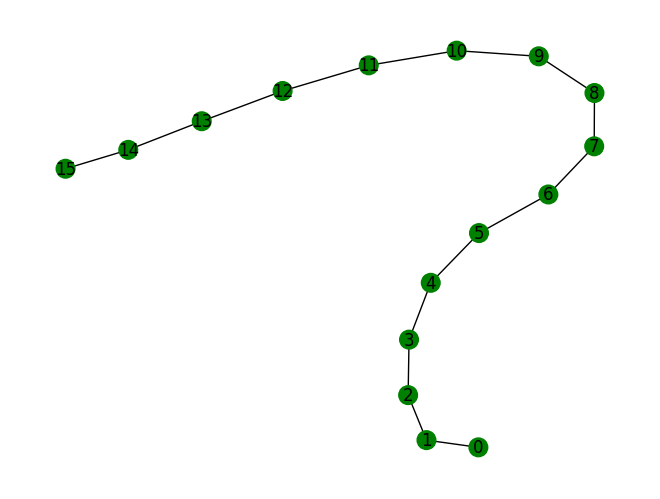

2
14794


In [ ]:
initial_network.draw()
print(num_partitions)

num_partitions = len(initial_qpu_sizes)

cost = calculate_full_cost_hetero(initial_graph, final_assignment, num_partitions, network=initial_network)

print(cost)

# draw_graph_tikz(initial_graph, final_assignment, initial_qpu_sizes)

In [ ]:
refined_cost, refined_assignment, _ = run_FM_hetero(initial_graph, final_assignment, initial_qpu_sizes, num_partitions,
                                                    passes=50, limit=num_qubits, network = initial_network, log=True,
                                                    costs={}
                                                    )



Initial cost: 14794
All passes complete.
Final cost: 13435


In [ ]:
list_ass, cost_list_rec, _ = MLFM_recursive_hetero(initial_graph, refined_assignment, initial_qpu_sizes, num_partitions,network=initial_network, costs = {}, log=True,level_limit=5)

Initial cost: 1590
All passes complete.
Final cost: 1348
Best cost at level 0: 1348
Initial cost: 1348
All passes complete.
Final cost: 1327
Best cost at level 1: 1327
Initial cost: 1327
All passes complete.
Final cost: 1300
Best cost at level 2: 1300
Initial cost: 1300
All passes complete.
Final cost: 1281
Best cost at level 3: 1281
Initial cost: 1281
All passes complete.
Final cost: 1272
Best cost at level 4: 1272


In [ ]:
draw_graph_tikz(initial_graph, list_ass[-1], initial_qpu_sizes)

qpu_info [9, 9, 9, 9, 9, 9, 9, 9]
[{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15, 16, 17], 2: [18, 19, 20, 21, 22, 23, 24, 25, 26], 3: [27, 28, 29, 30, 31, 32, 33, 34, 35], 4: [36, 37, 38, 39, 40, 41, 42, 43, 44], 5: [45, 46, 47, 48, 49, 50, 51, 52, 53], 6: [54, 55, 56, 57, 58, 59, 60, 61, 62], 7: [63, 64, 65, 66, 67, 68, 69, 70, 71]}, {0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15, 16, 17], 2: [18, 19, 20, 21, 22, 23, 24, 25, 26], 3: [27, 28, 29, 30, 31, 32, 33, 34, 35], 4: [36, 37, 38, 39, 40, 41, 42, 43, 44], 5: [45, 46, 47, 48, 49, 50, 51, 52, 53], 6: [54, 55, 56, 57, 58, 59, 60, 61, 62], 7: [63, 64, 65, 66, 67, 68, 69, 70, 71]}, {0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15, 16, 17], 2: [18, 19, 20, 21, 22, 23, 24, 25, 26], 3: [27, 28, 29, 30, 31, 32, 33, 34, 35], 4: [36, 37, 38, 39, 40, 41, 42, 43, 44], 5: [45, 46, 47, 48, 49, 50, 51, 52, 53], 6: [54, 55, 56, 57, 58, 59, 60, 61, 62], 7: [63, 64, 65, 66, 67, 68, 69, 70, 71]}, {0: [

Process SpawnPoolWorker-264:
Process SpawnPoolWorker-263:
Process SpawnPoolWorker-262:
Process SpawnPoolWorker-261:
Process SpawnPoolWorker-260:
Process SpawnPoolWorker-259:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process SpawnPoolWorker-258:
  File "/opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/pool.py", line 114, in worker
    t

KeyboardInterrupt: 